# Lab 4: Model-Based Offline Optimization

In this lab, we explore **Model-Based Offline Optimization (MBO)**, a method to optimize black-box functions using only a pre-collected dataset, without additional function evaluations. We'll use two functions from the **Black-Box Optimization Benchmarking (BBOB)** suite:
- **f1** [Sphere Function](https://numbbo.github.io/gforge/downloads/download16.00/bbobdocfunctions.pdf#page=5): A simple, unimodal function with a global minimum at (0, 0).
- **f22** [Gallagher's Gaussian 21-hi Peaks Function](https://numbbo.github.io/gforge/downloads/download16.00/bbobdocfunctions.pdf#page=110): A complex, multimodal function with many local optima.

Visualizations of these problems are available [here](https://coco-platform.org/testsuites/bbob/viz.html?col=3&dim=2&fun=1&ins=1&typ=all).

### Objectives
1. **Dataset:** Use pre-collected datasets (100k samples each) for f1 and f22, generated via **Latin Hypercube Sampling (LHS)** [learn more about LHS here](https://en.wikipedia.org/wiki/Latin_hypercube_sampling).
2. **Surrogate Model:** Train a Multi-Layer Perceptron (MLP) to approximate these functions.
3. **Visualization:** Compare the MLP's predictions to the true functions using contour and scatter plots.
4. **Optimization:** Implement gradient-based optimization on the MLP to find optimal points.
5. **Experiments:** Investigate how training dataset size and model complexity affect performance.

### Key Concepts
- **Offline Optimization:** No new evaluations of the true function are allowed; we rely solely on the dataset.
- **Surrogate Model:** The MLP acts as a cheap, differentiable proxy for the expensive black-box function.
- **Gradient-Based Optimization:** Use the MLP's gradients to find optimal designs efficiently.

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd

device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(device)

mps


### 1. Data Preparation

We start by loading and splitting the dataset into training, validation, and test sets.

In [14]:
def prepare_dataloaders(
    file_path: str,
    batch_size: int = 256,
    train_perc: float = 0.6,
    val_perc: float = 0.2,
) -> tuple[DataLoader, DataLoader, DataLoader]:
    """
    Prepare train, validation and test dataloaders.

    Args:
        file_path: Path to CSV data file
        batch_size: Batch size for dataloaders
        train_perc: Percentage of data for training
        val_perc: Percentage of data for validation
    """
    # Load data
    data_df = pd.read_csv(file_path)
    X = torch.tensor(data_df[["x1", "x2"]].values, dtype=torch.float32)
    y = torch.tensor(data_df["y"].values.reshape(-1, 1), dtype=torch.float32)

    # Split data
    num_samples = len(X)
    indices = np.random.permutation(num_samples)
    train_size = int(train_perc * num_samples)
    val_size = int(val_perc * num_samples)

    # Create datasets
    train_dataset = TensorDataset(X[indices[:train_size]], y[indices[:train_size]])
    val_dataset = TensorDataset(
        X[indices[train_size : train_size + val_size]],
        y[indices[train_size : train_size + val_size]],
    )
    test_dataset = TensorDataset(
        X[indices[train_size + val_size :]], y[indices[train_size + val_size :]]
    )

    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader

# Example usage (replace with your file path)
train_dataloader, val_dataloader, test_dataloader = prepare_dataloaders(
    "./bbob_f022_i01_d02_samples.csv", train_perc=0.3, val_perc=0.4
)

### 2. Define the MLP Model

The MLP will serve as our surrogate model to approximate the black-box function.

In [15]:
class MLP(nn.Module):
    def __init__(
        self, input_dim: int = 2, hidden_dim: int = 256, n_layers: int = 3
    ) -> None:
        """
        Multi-Layer Perceptron (MLP) for function approximation.

        Args:
            input_dim (int): Number of input features (e.g., 2 for x1, x2).
            hidden_dim (int): Number of neurons in each hidden layer.
            n_layers (int): Total number of layers (input + hidden + output).
        """
        super(MLP, self).__init__()

        layers = []
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())

        # Hidden layers
        for _ in range(n_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())

        # Output layer -> 1 output neuron (regression, single-objective problem)
        layers.append(nn.Linear(hidden_dim, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

### 3. Training the Model

We train the MLP using the Adam optimizer and Mean Squared Error (MSE) loss.

In [16]:
model = MLP().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, targets in train_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss = train_loss / len(train_dataloader.dataset)
    train_losses.append(train_loss)
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss = val_loss / len(val_dataloader.dataset)
    val_losses.append(val_loss)
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)

test_loss = test_loss / len(test_dataloader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Epoch 10/100, Train Loss: 614.4954, Val Loss: 548.9249
Epoch 20/100, Train Loss: 348.6434, Val Loss: 342.8752
Epoch 30/100, Train Loss: 287.6582, Val Loss: 283.3694
Epoch 40/100, Train Loss: 233.8348, Val Loss: 231.0272
Epoch 50/100, Train Loss: 199.0059, Val Loss: 193.5936
Epoch 60/100, Train Loss: 181.1179, Val Loss: 197.4178
Epoch 70/100, Train Loss: 169.1499, Val Loss: 166.1352
Epoch 80/100, Train Loss: 162.0281, Val Loss: 168.8163
Epoch 90/100, Train Loss: 155.1487, Val Loss: 151.9846
Epoch 100/100, Train Loss: 149.7846, Val Loss: 146.0604
Test Loss: 146.8037


### 4. Visualization

Let's visualize how well the MLP approximates the true function.

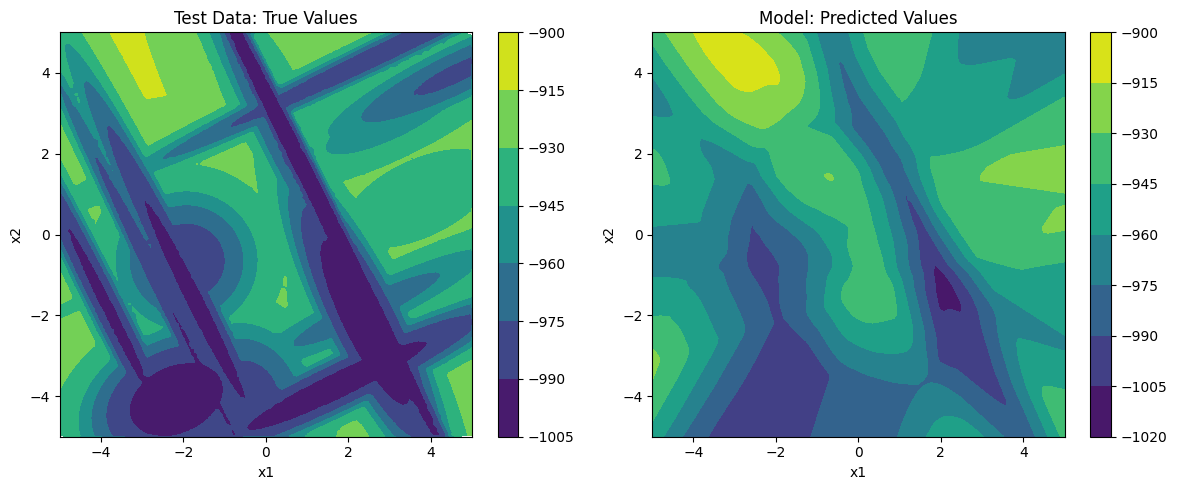

In [17]:
def plot_contour_comparison(
    model: nn.Module, test_dataloader: DataLoader, device: torch.device
) -> None:
    test_inputs_list = []
    test_targets_list = []

    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        test_inputs_list.append(inputs.cpu().numpy())
        test_targets_list.append(targets.cpu().numpy())

    test_inputs = np.vstack(test_inputs_list)
    test_targets = np.concatenate(test_targets_list)

    x1_min, x1_max = test_inputs[:, 0].min(), test_inputs[:, 0].max()
    x2_min, x2_max = test_inputs[:, 1].min(), test_inputs[:, 1].max()
    x1_vals = np.linspace(x1_min, x1_max, 100)
    x2_vals = np.linspace(x2_min, x2_max, 100)
    X1, X2 = np.meshgrid(x1_vals, x2_vals)

    grid_points = np.column_stack((X1.flatten(), X2.flatten()))
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32, device=device)

    model.eval()
    with torch.no_grad():
        predictions = model(grid_tensor).cpu().numpy().flatten()

    Z_pred = predictions.reshape(X1.shape)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    true_contour = ax1.tricontourf(
        test_inputs[:, 0], test_inputs[:, 1], test_targets.reshape(-1)
    )
    ax1.set_title("Test Data: True Values")
    ax1.set_xlabel("x1")
    ax1.set_ylabel("x2")
    plt.colorbar(true_contour, ax=ax1)

    pred_contour = ax2.contourf(X1, X2, Z_pred)
    ax2.set_title("Model: Predicted Values")
    ax2.set_xlabel("x1")
    ax2.set_ylabel("x2")
    plt.colorbar(pred_contour, ax=ax2)

    plt.tight_layout()
    plt.show()

plot_contour_comparison(model, test_dataloader, device)

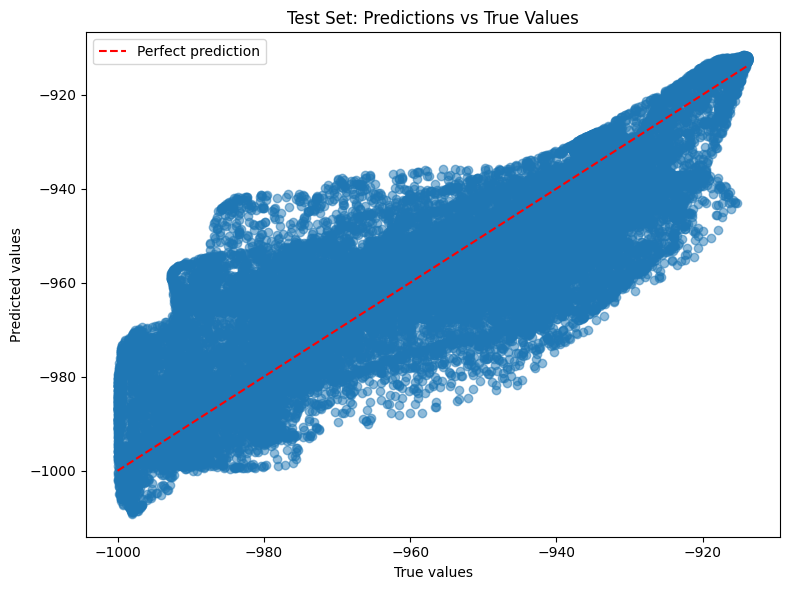

In [18]:
def plot_prediction_scatter(
    model: nn.Module, test_dataloader: DataLoader, device: torch.device
) -> None:
    test_targets_list = []
    test_preds_list = []

    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.no_grad():
            outputs = model(inputs)

        test_targets_list.append(targets.cpu().numpy())
        test_preds_list.append(outputs.cpu().numpy())

    test_targets = np.concatenate(test_targets_list)
    test_preds = np.concatenate(test_preds_list).flatten()

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(test_targets, test_preds, alpha=0.5)
    ax.plot(
        [test_targets.min(), test_targets.max()],
        [test_targets.min(), test_targets.max()],
        "r--",
        label="Perfect prediction",
    )
    ax.set_xlabel("True values")
    ax.set_ylabel("Predicted values")
    ax.set_title("Test Set: Predictions vs True Values")
    ax.legend()

    plt.tight_layout()
    plt.show()


plot_prediction_scatter(model, test_dataloader, device)

### 5. Gradient-Based Optimization

Now, we optimize the trained MLP to find the input that minimizes its output (our surrogate's prediction).

In [20]:
def optimize_model(
    model: nn.Module, num_steps: int = 1000, lr: float = 0.01
) -> tuple[torch.Tensor, float]:
    """
    Perform gradient-based optimization on the MLP.

    Args:
        model (nn.Module): Trained MLP model.
        num_steps (int): Number of optimization steps.
        lr (float): Learning rate for the optimizer.

    Returns:
        tuple: (best_x, best_y) - Optimal input and its predicted output.
    """
    model.eval()

    # Select a random starting point in the domain [-5, 5]^2
    x = torch.rand(1, 2, device=device) * 10 - 5
    x.requires_grad_(True) 

    optimizer = torch.optim.Adam([x], lr=lr)

    for _ in range(num_steps):
        optimizer.zero_grad()

        output = model(x)

        loss = output
        loss.backward()

        optimizer.step()

        x.data = torch.clamp(x.data, -5, 5)

    return x.detach(), model(x).item()

### Exercise 1: Impact of Dataset Size
- **Task:** Train the MLP with different training set sizes (e.g., 100, 1000, 5000, 10000, 50000).
- **Instructions:**
  1. Modify the `train_perc` parameter in `prepare_dataloaders` to achieve these different dataset sizes (keep the test set size fixed at approximately 30,000 samples).
  2. Train the model for each dataset size and generate corresponding contour plots.
  3. Analyze how the MLP's ability to capture the underlying function structure (particularly the multimodal nature of f22) improves with increasing data volume.
  4. Select and justify a single quantitative metric that effectively captures the model’s predictive quality in this context. Use this metric to evaluate model performance across different training set sizes. Present the results as a plot to visualize how model quality scales with data availability.

### Exercise 2: Optimization Robustness
- **Task:** Implement the `optimize_model` function to find inputs that minimize the model's output.
- **Instructions:**
  1. Execute the optimization process multiple times (e.g. 10 for each dataset) with different random starting points and record the best surrogate values.
  2. Create a histogram of the best `y` values across all optimization runs to visualize the distribution of results.
  3. Generate a contour plot showing the locations of the solutions found. Analyze the consistency of these solutions.
  4. Use `cocoex` to evaluate the true objective function at the solution points. Compare these values against the surrogate’s predicted values.

Train size: 100, Train perc: 0.001, Val perc: 0.699
Epoch 10/100, Train Loss: 896008.9375, Val Loss: 904548.8388
Epoch 20/100, Train Loss: 868322.1250, Val Loss: 876708.2924
Epoch 30/100, Train Loss: 825357.4375, Val Loss: 833947.3394
Epoch 40/100, Train Loss: 764085.1250, Val Loss: 773362.7874
Epoch 50/100, Train Loss: 682905.1875, Val Loss: 693514.0044
Epoch 60/100, Train Loss: 583070.5625, Val Loss: 595704.7314
Epoch 70/100, Train Loss: 469785.5938, Val Loss: 484954.4961
Epoch 80/100, Train Loss: 352646.2812, Val Loss: 370351.4731
Epoch 90/100, Train Loss: 245216.0312, Val Loss: 264676.8615
Epoch 100/100, Train Loss: 161704.2344, Val Loss: 181186.3354
Train size: 100, Test MSE: 181228.0716


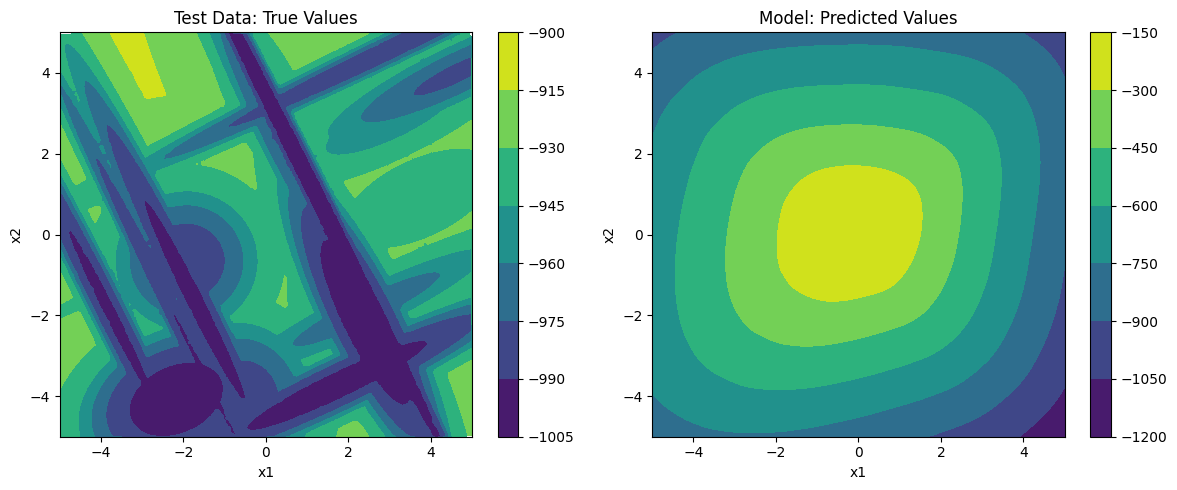

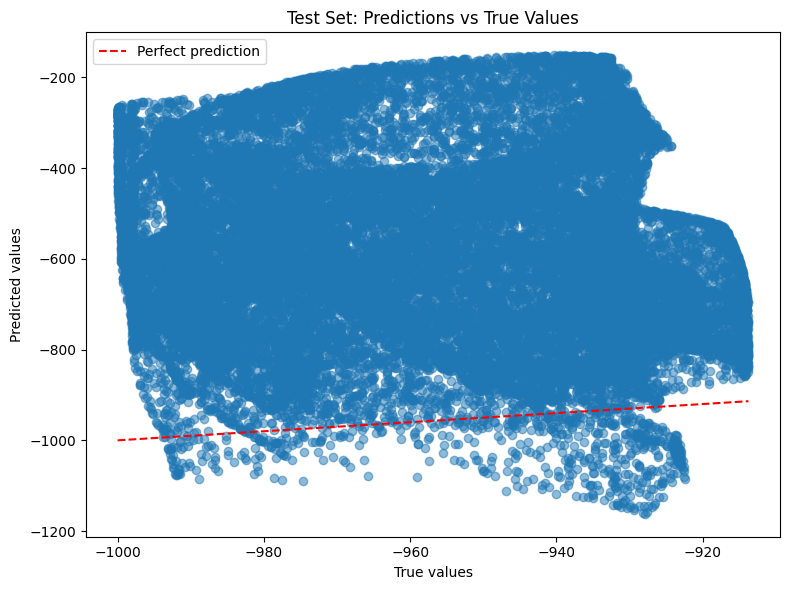

Train size: 1000, Train perc: 0.01, Val perc: 0.69
Epoch 10/100, Train Loss: 796049.8440, Val Loss: 778224.7674
Epoch 20/100, Train Loss: 412540.7357, Val Loss: 380978.2460
Epoch 30/100, Train Loss: 97309.2033, Val Loss: 92322.7432
Epoch 40/100, Train Loss: 78315.2703, Val Loss: 80307.5971
Epoch 50/100, Train Loss: 74571.3563, Val Loss: 76495.6489
Epoch 60/100, Train Loss: 70859.4178, Val Loss: 72705.0226
Epoch 70/100, Train Loss: 66870.2081, Val Loss: 68603.7853
Epoch 80/100, Train Loss: 62587.2699, Val Loss: 64198.5804
Epoch 90/100, Train Loss: 58009.6027, Val Loss: 59455.4660
Epoch 100/100, Train Loss: 53083.3107, Val Loss: 54374.3722
Train size: 1000, Test MSE: 53887.4610


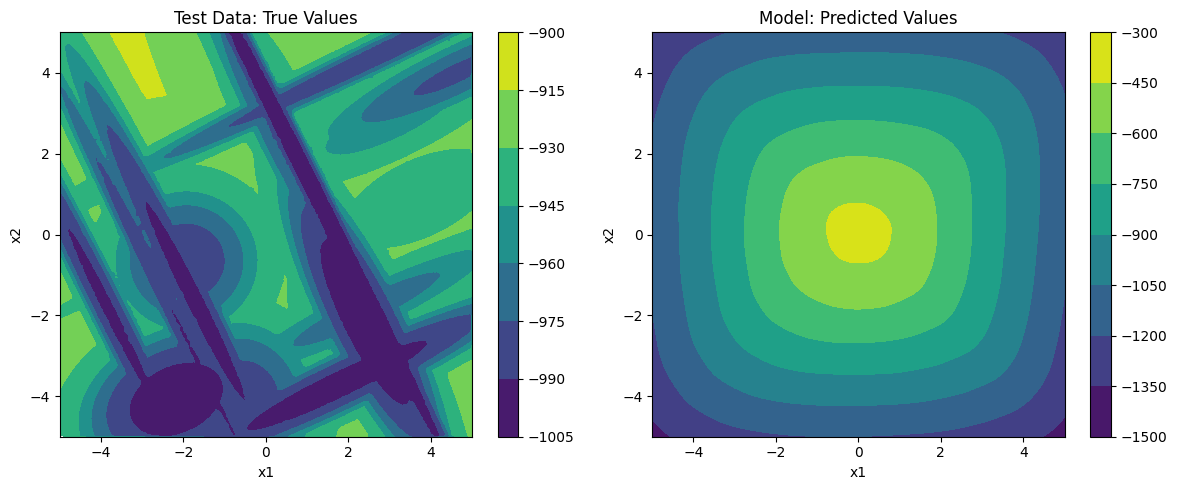

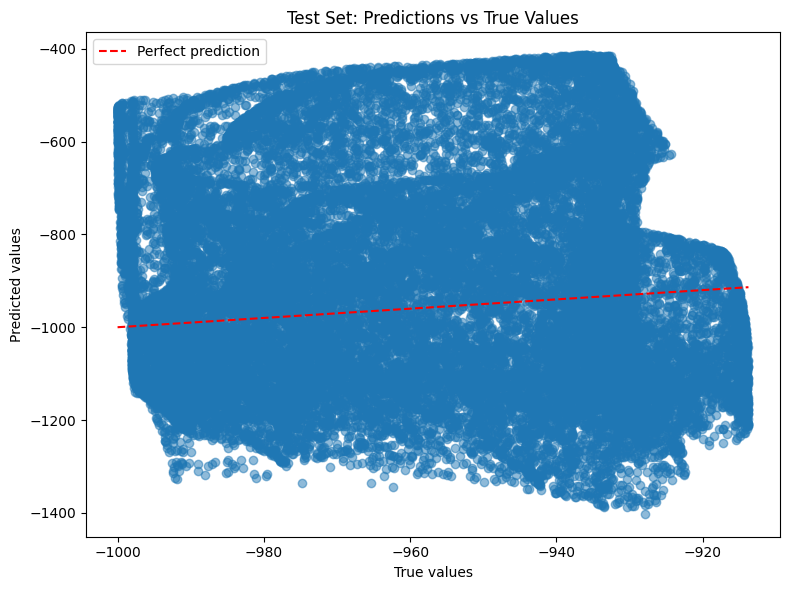

Train size: 5000, Train perc: 0.05, Val perc: 0.65
Epoch 10/100, Train Loss: 80408.1738, Val Loss: 79544.4802
Epoch 20/100, Train Loss: 58474.7896, Val Loss: 57282.8767
Epoch 30/100, Train Loss: 31250.4109, Val Loss: 29911.4556
Epoch 40/100, Train Loss: 9760.3117, Val Loss: 9080.3291
Epoch 50/100, Train Loss: 1256.2581, Val Loss: 1166.7814
Epoch 60/100, Train Loss: 487.3728, Val Loss: 497.2832
Epoch 70/100, Train Loss: 404.8865, Val Loss: 415.1588
Epoch 80/100, Train Loss: 366.5861, Val Loss: 376.5857
Epoch 90/100, Train Loss: 343.5065, Val Loss: 355.0367
Epoch 100/100, Train Loss: 328.1213, Val Loss: 339.1358
Train size: 5000, Test MSE: 343.4659


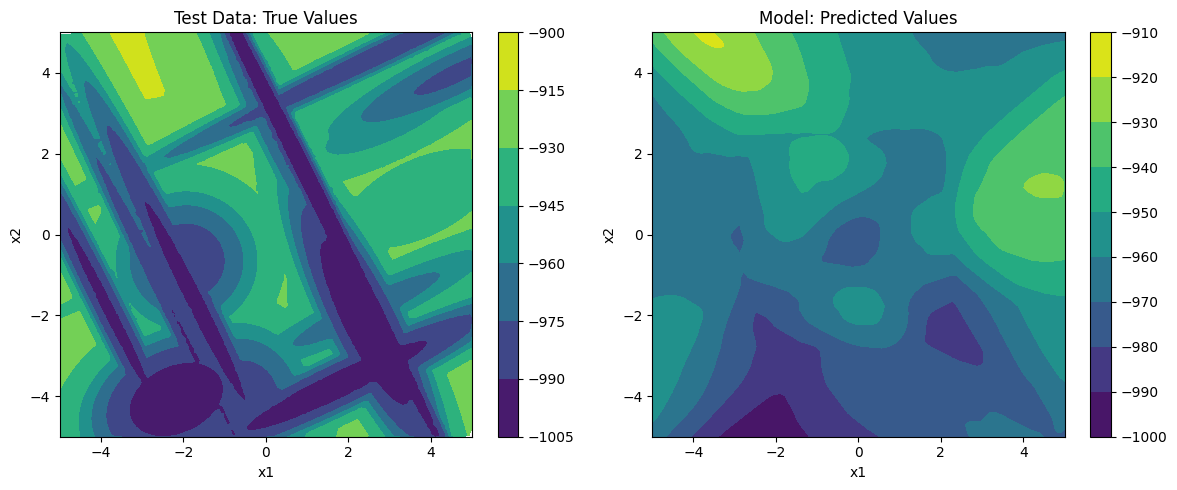

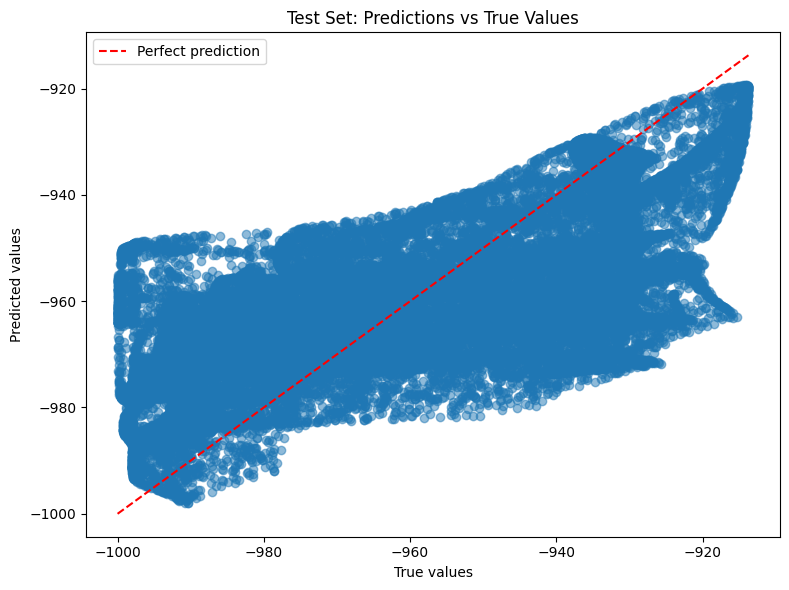

Train size: 10000, Train perc: 0.1, Val perc: 0.6
Epoch 10/100, Train Loss: 54942.3957, Val Loss: 53326.8308
Epoch 20/100, Train Loss: 6088.7933, Val Loss: 4967.0550
Epoch 30/100, Train Loss: 480.9636, Val Loss: 482.0436
Epoch 40/100, Train Loss: 384.1252, Val Loss: 384.8237
Epoch 50/100, Train Loss: 337.3664, Val Loss: 341.5120
Epoch 60/100, Train Loss: 303.0169, Val Loss: 303.5957
Epoch 70/100, Train Loss: 282.4232, Val Loss: 280.6359
Epoch 80/100, Train Loss: 261.2676, Val Loss: 261.5630
Epoch 90/100, Train Loss: 242.1543, Val Loss: 243.1912
Epoch 100/100, Train Loss: 225.2818, Val Loss: 224.3891
Train size: 10000, Test MSE: 225.5980


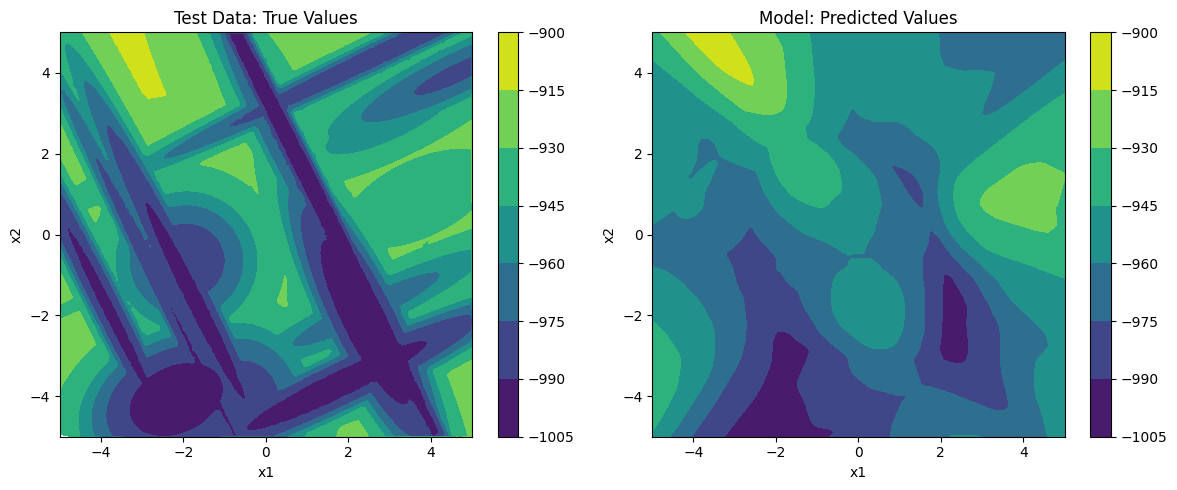

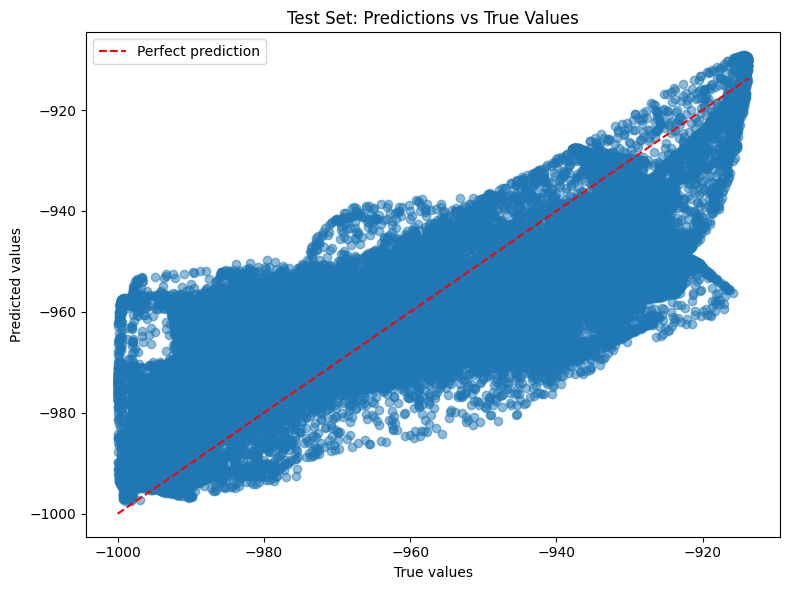

Train size: 50000, Train perc: 0.5, Val perc: 0.2
Epoch 10/100, Train Loss: 438.2066, Val Loss: 428.5293
Epoch 20/100, Train Loss: 293.8869, Val Loss: 287.9977
Epoch 30/100, Train Loss: 200.7227, Val Loss: 197.4130
Epoch 40/100, Train Loss: 162.5115, Val Loss: 159.2453
Epoch 50/100, Train Loss: 139.7694, Val Loss: 134.3724
Epoch 60/100, Train Loss: 125.8344, Val Loss: 124.0835
Epoch 70/100, Train Loss: 116.8983, Val Loss: 120.2150
Epoch 80/100, Train Loss: 110.2582, Val Loss: 107.5423
Epoch 90/100, Train Loss: 105.2584, Val Loss: 105.3380
Epoch 100/100, Train Loss: 101.9851, Val Loss: 99.5509
Train size: 50000, Test MSE: 100.6334


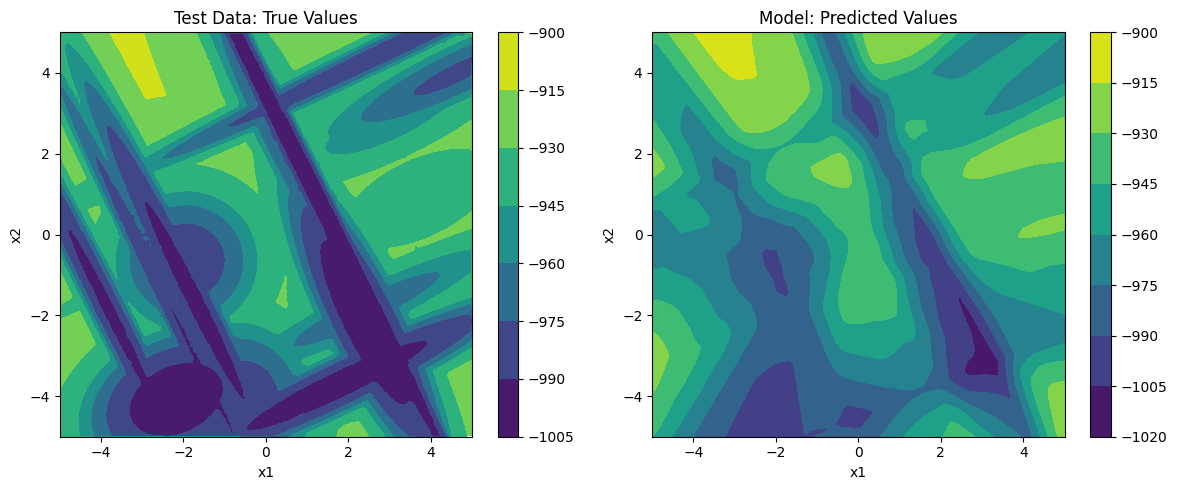

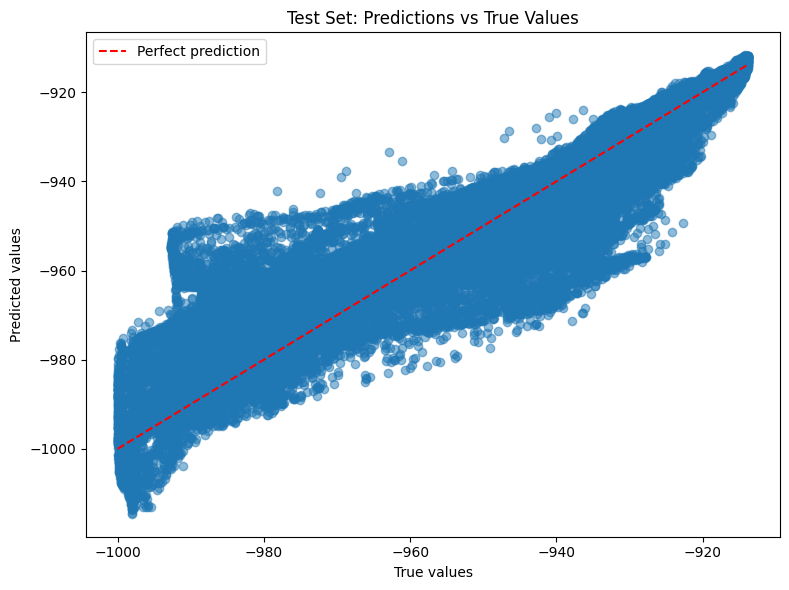

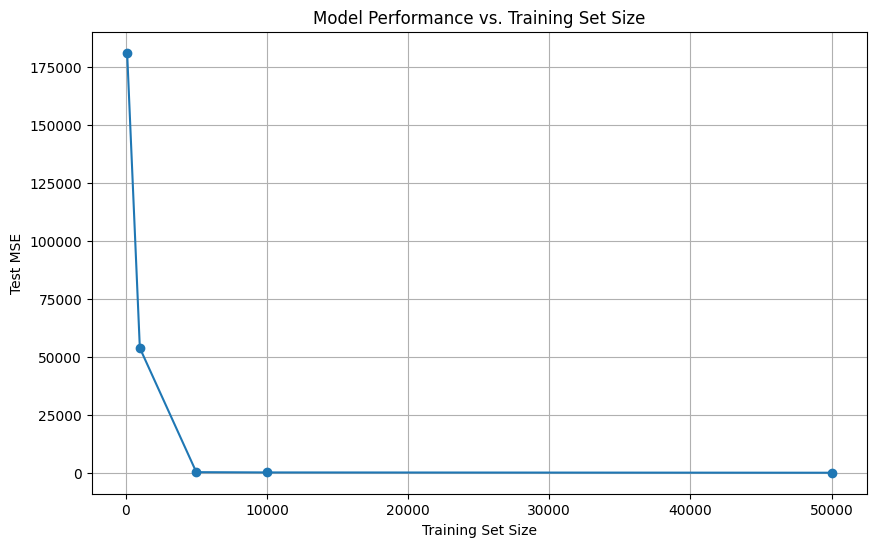

In [19]:
# Define training sizes
train_sizes = [100, 1000, 5000, 10000, 50000]
total_samples = 100000
test_size = 30000  # Fixed test set size
mse_results = []

for train_size in train_sizes:
    # Calculate train_perc based on the desired training size
    train_perc = train_size / total_samples
    val_perc = (total_samples - train_size - test_size) / total_samples
    print(f"Train size: {train_size}, Train perc: {train_perc}, Val perc: {val_perc}")
    
    # Prepare dataloaders
    train_dataloader, _, test_dataloader = prepare_dataloaders(
        "./bbob_f022_i01_d02_samples.csv", train_perc=train_perc, val_perc=val_perc
    )
    
    # Initialize model, loss, and optimizer
    model = MLP().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    train_loses = []
    val_losses = []
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        train_loss = train_loss / len(train_dataloader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        val_loss = val_loss / len(val_dataloader.dataset)
        val_losses.append(val_loss)
        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
            )
            
    # Evaluate the model on the test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
    
    test_loss = test_loss / len(test_dataloader.dataset)
    mse_results.append(test_loss)
    print(f"Train size: {train_size}, Test MSE: {test_loss:.4f}")

    plot_contour_comparison(model, test_dataloader, device)
    plot_prediction_scatter(model, test_dataloader, device)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, mse_results, marker='o')
plt.xlabel("Training Set Size")
plt.ylabel("Test MSE")
plt.title("Model Performance vs. Training Set Size")
plt.grid()
plt.show()

In [28]:
 # 1. Execute the optimization process multiple times (e.g. 10 for each dataset) with different random starting points and record the best surrogate values.
num_runs = 10
solutions = []
surrogate_values = []

for _ in range(num_runs):
    best_x, best_y = optimize_model(model, num_steps=1000, lr=0.01)
    solutions.append(best_x.cpu().numpy())
    surrogate_values.append(best_y)

# Convert solutions to a NumPy array
solutions = np.array(solutions)

Run 1: Best x = [[-2.4711738 -5.       ]], Surrogate Value = -994.5568
Run 2: Best x = [[-0.06437757 -4.561358  ]], Surrogate Value = -996.9334
Run 3: Best x = [[5.       4.234806]], Surrogate Value = -973.8622
Run 4: Best x = [[-0.5628459  4.519103 ]], Surrogate Value = -986.6990
Run 5: Best x = [[-3.2371979  1.4754776]], Surrogate Value = -987.8055
Run 6: Best x = [[ 3.236759  -3.1830873]], Surrogate Value = -1014.9360
Run 7: Best x = [[2.9857736 4.6551685]], Surrogate Value = -970.4078
Run 8: Best x = [[ 3.240397 -3.188008]], Surrogate Value = -1014.9340
Run 9: Best x = [[-2.1434345 -0.6053087]], Surrogate Value = -993.7304
Run 10: Best x = [[ 2.6722293 -2.031701 ]], Surrogate Value = -1008.0800


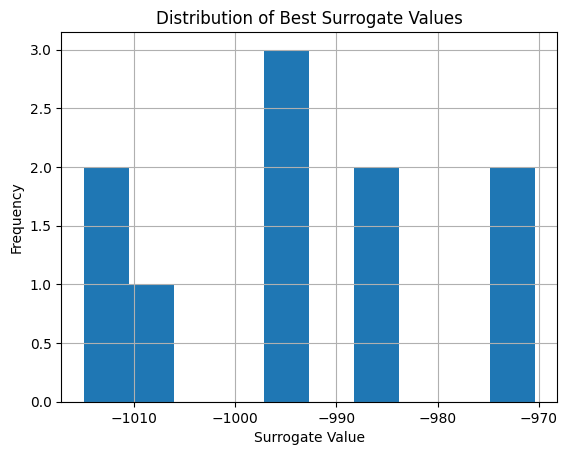

In [29]:
# Print results
for i, (x, y) in enumerate(zip(solutions, surrogate_values)):
    print(f"Run {i+1}: Best x = {x}, Surrogate Value = {y:.4f}")
#Create a histogram of the best `y` values across all optimization runs to visualize the distribution of results.
plt.hist(surrogate_values, bins=10)
plt.xlabel("Surrogate Value")
plt.ylabel("Frequency")
plt.title("Distribution of Best Surrogate Values")
plt.grid()
plt.show()

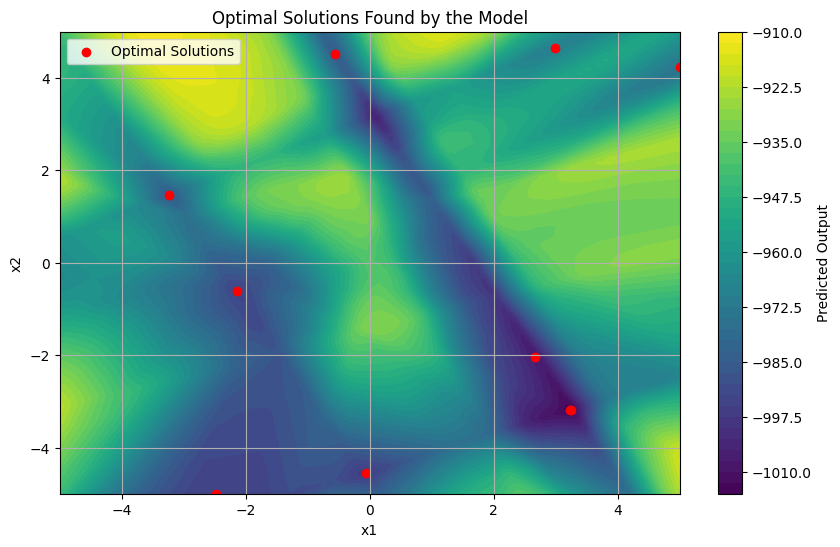

In [33]:
# Ensure solutions is a 2D array with shape (num_runs, 2)
solutions = np.squeeze(solutions)  # Remove the extra dimension

# Generate a grid of points in the domain [-5, 5]^2
X, Y = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))

# Evaluate the model on the grid
Z = []
for x, y in zip(X.ravel(), Y.ravel()):
    input_tensor = torch.tensor([[x, y]], dtype=torch.float32, device=device)  # Ensure input is 2D
    output = model(input_tensor).item()  # Get scalar output
    Z.append(output)

Z = np.array(Z).reshape(X.shape)  # Reshape to match the grid

# Plot the contour
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, Z, levels=50, cmap="viridis")  # Contour plot of the model's output
plt.colorbar(label="Predicted Output")
plt.scatter(solutions[:, 0], solutions[:, 1], color="red", label="Optimal Solutions")  # Overlay solutions
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Optimal Solutions Found by the Model")
plt.legend()
plt.grid()
plt.show()

### Accessing Original COCO Benchmark Problems

The code below installs and imports the necessary packages to access the original COCO benchmark problems (f1 and f22).
This will allow us to compare our model's predictions with the true functions and evaluate optimization performance.

In [ ]:
! pip install coco-experiment cocopp

Comparison of True and Surrogate Values:
Solution 1: True Value = -990.0093, Surrogate Value = -994.5568
Solution 2: True Value = -992.0548, Surrogate Value = -996.9334
Solution 3: True Value = -977.6786, Surrogate Value = -973.8622
Solution 4: True Value = -997.9484, Surrogate Value = -986.6990
Solution 5: True Value = -985.7064, Surrogate Value = -987.8055
Solution 6: True Value = -997.9875, Surrogate Value = -1014.9360
Solution 7: True Value = -987.4247, Surrogate Value = -970.4078
Solution 8: True Value = -997.9873, Surrogate Value = -1014.9340
Solution 9: True Value = -993.1433, Surrogate Value = -993.7304
Solution 10: True Value = -999.4934, Surrogate Value = -1008.0800

Absolute Errors:
Solution 1: Absolute Error = 4.5475
Solution 2: Absolute Error = 4.8786
Solution 3: Absolute Error = 3.8163
Solution 4: Absolute Error = 11.2494
Solution 5: Absolute Error = 2.0991
Solution 6: Absolute Error = 16.9485
Solution 7: Absolute Error = 17.0169
Solution 8: Absolute Error = 16.9468
Solut

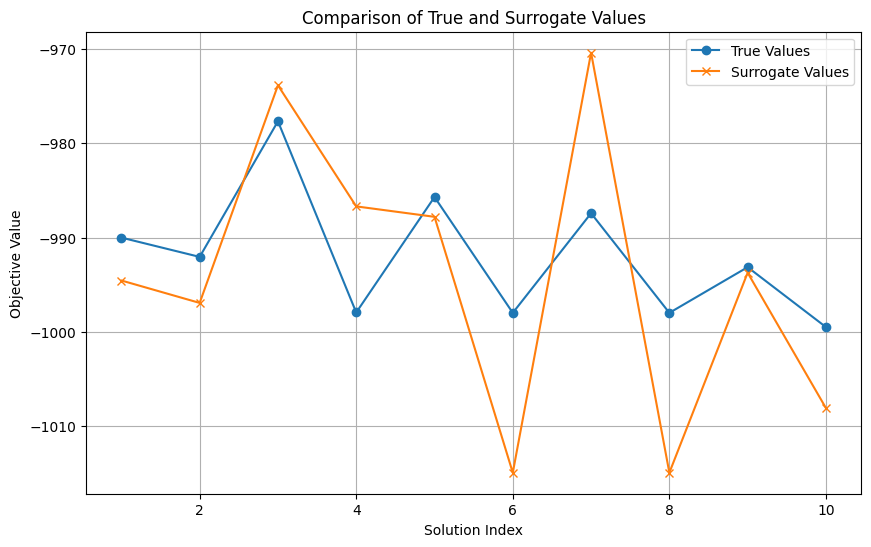

In [ ]:
from cocoex import Suite

function_id = 22  
suite = Suite(
    "bbob",
    "",
    f"function_indices: {function_id}, dimensions: 2, instance_indices: 1",
)
function = suite[0]

true_values = []
for solution in solutions:
    true_value = function(solution) 
    true_values.append(true_value)

surrogate_values = []
for solution in solutions:
    input_tensor = torch.tensor(solution, dtype=torch.float32, device=device).unsqueeze(0) 
    surrogate_value = model(input_tensor).item() 
    surrogate_values.append(surrogate_value)

print("Comparison of True and Surrogate Values:")
for i, (true, surrogate) in enumerate(zip(true_values, surrogate_values)):
    print(f"Solution {i+1}: True Value = {true:.4f}, Surrogate Value = {surrogate:.4f}")

absolute_errors = [abs(true - surrogate) for true, surrogate in zip(true_values, surrogate_values)]
print("\nAbsolute Errors:")
for i, error in enumerate(absolute_errors):
    print(f"Solution {i+1}: Absolute Error = {error:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(true_values) + 1), true_values, label="True Values", marker="o")
plt.plot(range(1, len(surrogate_values) + 1), surrogate_values, label="Surrogate Values", marker="x")
plt.xlabel("Solution Index")
plt.ylabel("Objective Value")
plt.title("Comparison of True and Surrogate Values")
plt.legend()
plt.grid()
plt.show()